## Imports

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from networks.adversarial_model import EncoderDecoder
from networks.gan import Generator, UnFlatten, Flatten
from slf_dataset import SLF, SLFDataset, plot_image_output, plot_image
import os
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import time
from networks.gan import Generator128, Generator, Generator256, Generator512
from networks.model_utils import *
from psd_recovery.nn_descent_gan import inverse_gan2
z_dim = 64


## model and data paths

In [8]:
AE_MODEL_PATH = '/nfs/stak/users/shressag/sagar/deep_completion/deep_slf/models/full_data_models/mse2_ed_rand_samp.model'
# GAN_MODEL_PATH = 'trained-models/gan/gen3'
GAN_MODEL_PATH = 'trained-models/gan/sngan2'
GAN_MODEL_PATH2 = 'trained-models/gan/sngan4_jan9_80_epochs'
GAN_MODEL_PATH3 = 'trained-models/gan/sngan5_tvloss'
GAN_MODEL_PATH4 = 'trained-models/gan/sngan6_128'
GAN_MODEL_PATH5 = 'trained-models/gan/sngan7_256'
GAN_MODEL_PATH6 = 'trained-models/gan/sngan8_512'



AE_RAW_MODEL_PATH = '/nfs/stak/users/shressag/sagar/deep_completion/deep_slf/models/full_data_models/l1_5_unnorm_raw_rand_samp.model'
GAN_RAW_MODEL_PATH = '/scratch/sagar/Projects/matlab/radio_map_deep_prior/deep_prior/trained-models/gan/gen2_lr_0.0001_d_lr_0.0004_normalize_False'

TRAIN_DATA_PATH = '/scratch/sagar/slf/train_set/2m_data/'
# Log data
TEST_DATA_PATH1 = '/scratch/sagar/slf/train_set/set_harsh'
TEST_DATA_PATH = '/scratch/sagar/slf/test_set/test_jan_torch_raw'

# Raw Data
# TEST_DATA_PATH = '/scratch/sagar/slf/train_set/set_harsh_torch_raw_unnormalized'


class SLFGen(Dataset):
    """SLF loader"""

    def __init__(self, root_dir=None, generator=None, csv_file=None, transform=None, total_data=None, normalize=True, sample_size=[0.01,0.20], fixed_size=None, fixed_mask=False, no_sampling=False):
        """
        Args:
            csv_file (string): Path to the csv file with params.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            total_data: Number of data points
            normalize: Whether to normalize such that the largest value is 1
            sample_size: range off sampling percentage
            fixed_size: if not none, fixed_size will be used as the sampling size
            fixed_mask: if true, the same mask will be used 
        """
        self.generator = generator
        self.root_dir = root_dir
        self.transform = transform
        self.NUM_SAMPLES = int(0.20*51*51)
        self.nrow, self.ncol = (51, 51)
        if not total_data is None:
            self.num_examples = total_data
        else:
            self.num_examples = 500000
        self.sampling_rate = sample_size[1]-sample_size[0]
        self.omega_start_point = 1.0 - sample_size[1]
        
        if fixed_size:
            self.sampling_rate = 0
            self.omega_start_point = 1.0 - fixed_size
        
        self.fixed_mask = fixed_mask
        self.no_sampling = no_sampling
        if self.fixed_mask:
            rand = self.sampling_rate*torch.rand(1).item()
            self.bool_mask = torch.FloatTensor(1,51,51).uniform_() > (self.omega_start_point+rand)
            self.int_mask = self.bool_mask*torch.ones((1,51,51), dtype=torch.float32)
        
    def __len__(self):
        return self.num_examples

    def __getitem__(self, idx):

        z = torch.randn((1,256), dtype=torch.float32)
        sample = self.generator(z)
        sample = sample.squeeze(dim=0)
        sample = sample.detach()
        
        if self.no_sampling:
            return sample
        
        if not self.fixed_mask:
            rand = self.sampling_rate*torch.rand(1).item()
            bool_mask = torch.FloatTensor(1,51,51).uniform_() > (self.omega_start_point+rand)
            int_mask = bool_mask*torch.ones((1,51,51), dtype=torch.float32)
            sampled_slf = sample*bool_mask
        else:
            int_mask = self.int_mask
            sampled_slf = sample*self.bool_mask
        
        return torch.cat((int_mask,sampled_slf), dim=0), sample

## Generate fake samples

In [9]:
generator = Generator256()
GAN_PATH = '/home/sagar/Projects/matlab/radio_map_deep_prior/deep_prior/trained-models/gan/sngan11_256_unnorm'
GAN_PATH_SERVER = '/scratch/sagar/Projects/matlab/radio_map_deep_prior/deep_prior/trained-models/gan/sngan7_256'

try:
    checkpoint = torch.load(GAN_PATH, map_location=torch.device('cpu'))
except:
    checkpoint = torch.load(GAN_PATH_SERVER, map_location=torch.device('cpu'))
    
generator.load_state_dict(checkpoint['g_model_state_dict'])
generator.eval()

data_set = SLFGen(generator=generator, normalize=False, no_sampling=True)

In [76]:
import numpy as np
import scipy.io

data_path = '/home/sagar/Projects/matlab/radio_map_deep_prior/psd_recovery/data/fake/slf_mat'
for i in range(100):
    sample = data_set[i]
    scipy.io.savemat(os.path.join(data_path,'{0:07d}'.format(i)+'.mat'), dict(Sc=sample.squeeze().numpy()))   

x = np.linspace(0, 2 * np.pi, 100)
y = np.cos(x)



In [65]:
y = np.cos(54)

In [69]:
y = np.array([3,33,3])

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [62]:
a = data_set[0]

In [63]:
a.shape

torch.Size([1, 51, 51])

## tests

In [3]:
autoencoder = EncoderDecoder()
checkpoint = torch.load(AE_MODEL_PATH)
autoencoder.load_state_dict(checkpoint['model_state_dict'])

generator = Generator()
checkpoint = torch.load(GAN_MODEL_PATH)
generator.load_state_dict(checkpoint['g_model_state_dict'])


generator_tv = Generator()
checkpoint = torch.load(GAN_MODEL_PATH3)
generator_tv.load_state_dict(checkpoint['g_model_state_dict'])


generator_128 = Generator128()
checkpoint = torch.load(GAN_MODEL_PATH4)
generator_128.load_state_dict(checkpoint['g_model_state_dict'])
generator_128.eval()
generator_128 = generator_128.to('cpu')


generator_256 = Generator256()
checkpoint = torch.load(GAN_MODEL_PATH5)
generator_256.load_state_dict(checkpoint['g_model_state_dict'])
generator_256.eval()
generator_256 = generator_256.to('cpu')


generator_512 = Generator512()
checkpoint = torch.load(GAN_MODEL_PATH6)
generator_512.load_state_dict(checkpoint['g_model_state_dict'])
generator_512.eval()
generator_512 = generator_512.to('cpu')

# generator2 = Generator()
# checkpoint = torch.load(GAN_MODEL_PATH2)
# generator2.load_state_dict(checkpoint['g_model_state_dict'])

autoencoder_raw = EncoderDecoder()
checkpoint = torch.load(AE_RAW_MODEL_PATH)
autoencoder_raw.load_state_dict(checkpoint['model_state_dict'])

generator_raw = torch.load(GAN_RAW_MODEL_PATH)
generator_raw.eval()
generator_raw = generator_raw.to('cpu')

generator.eval()
generator = generator.to('cpu')

generator_tv.eval()
generator_tv = generator_tv.to('cpu')


test_set = SLF(os.path.join(TEST_DATA_PATH, 'slf_mat'), normalize=True, sampling = True)
test_set2 = SLFDataset(root_dir=os.path.join(TEST_DATA_PATH, 'slf_mat'), 
                     csv_file=os.path.join(TEST_DATA_PATH, 'details.csv'), fixed_size=0.1)


## optimizer

In [4]:
loop_count = 500
lr = 0.1
criterion = nn.MSELoss()
print_out = False

def run_descent(generator, mask, sampled_slf, print_out=False, z_dimension=64):
    global lr
    Wx = mask
    z = torch.randn((1,z_dimension), dtype=torch.float32)
    
    # First select a good random vector
    min_criterion = 9999999
    for i in range(400):
        temp = torch.randn((1,z_dimension), dtype=torch.float32)
        temp_out = generator(temp)
        temp_criterion = criterion(Wx*temp_out, Wx*sampled_slf) 
        if  temp_criterion < min_criterion:
            z.data = temp.clone()
            min_criterion = temp_criterion
            print('min_first', min_criterion)

    for i in range(200):
        temp = 0.2*torch.randn((1,z_dimension), dtype=torch.float32) + z
        temp_out = generator(temp)
        temp_criterion = criterion(Wx*temp_out, Wx*sampled_slf) 
        if  temp_criterion < min_criterion:
            z.data = temp.clone()
            min_criterion = temp_criterion
            print('min_second', min_criterion)

    z.requires_grad = True
    optimizer = torch.optim.Adam([z], lr=0.01)
    
    for i in range(loop_count):
        optimizer.zero_grad()
        
        gen_out = generator(z)
        loss = criterion((Wx*gen_out), (Wx*sampled_slf))
        # print(loss)
        loss.backward()
        optimizer.step()
#         with torch.no_grad():
#             z -= lr*z.grad
#         z.grad.data.zero_()
        if print_out:
            actual_loss = criterion(gen_out, true)
            clear_output(wait=True)
            print(lr, loss.item(), actual_loss.item())
            plot_image_output(gen_out)
            plt.show()
            time.sleep(0.1)
    actual_loss = criterion(gen_out, true)
    
    return actual_loss, generator(z)


## Plot performance graphs with real samples

In [24]:
# with real dataset

ae_loss = []
gan_loss_256 = []
gan_loss_512 = []
gan_loss_64 = []
fs = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2]
# fs = [0.1]
for f in fs:
#     test_set2 = SLFDataset(root_dir=os.path.join(TEST_DATA_PATH, 'slf_mat'), 
#                          csv_file=os.path.join(TEST_DATA_PATH, 'details.csv'), fixed_size=f)
    test_set2 = SLF(os.path.join(TEST_DATA_PATH, 'slf_mat'), sampling=True, normalize=True, fixed_size=f)

    total_data = 10
    ae_total = 0
    gan_total_256 = 0
    gan_total_512 = 0
    gan_total_64 = 0
    for i in range(600,600+total_data):
        inp, true = test_set2[i]
#         torch.save(, 'test_slf_comp')
#         torch.save(inp, 'test_slf_samp')
        print(i-100)
        # compute ae_loss
        ae_out = autoencoder(inp.unsqueeze(dim=0))
#         plot_image_output(ae_out)
        loss = criterion(ae_out.squeeze(), true.squeeze())
        ae_total += loss
        print('ae_loss', loss.item())
    
        #compute gan_loss
        loss, _ = run_descent(generator_256, inp[0], inp[1], z_dimension=256)
        gan_total_256 += loss
        print('gan_loss_256', loss.item())
        
        #compute gan_loss_tv
        loss, _ = run_descent(generator_512, inp[0], inp[1], z_dimension=512)
        gan_total_512 += loss
        print('gan_loss_512', loss.item())
        
#         #compute gan_loss_tv
#         loss, gan_out_64 = run_descent(generator_tv, inp[0], inp[1], z_dimension=64)
#         gan_total_64 += loss
#         print('gan_loss_64', loss.item())
        
        
    ae_loss.append(ae_total/total_data)
    gan_loss_256.append(gan_total_256/total_data)
    gan_loss_512.append(gan_total_512/total_data)
    
        

500
ae_loss 0.03820589929819107
min_first tensor(7.4289e-05, grad_fn=<MseLossBackward>)
min_first tensor(2.6162e-05, grad_fn=<MseLossBackward>)
min_first tensor(1.9509e-05, grad_fn=<MseLossBackward>)
min_first tensor(1.8385e-05, grad_fn=<MseLossBackward>)
min_first tensor(8.9025e-06, grad_fn=<MseLossBackward>)
min_first tensor(8.7500e-06, grad_fn=<MseLossBackward>)
min_second tensor(7.8457e-06, grad_fn=<MseLossBackward>)
min_second tensor(7.2183e-06, grad_fn=<MseLossBackward>)
min_second tensor(3.8998e-06, grad_fn=<MseLossBackward>)
min_second tensor(2.4699e-06, grad_fn=<MseLossBackward>)
min_second tensor(2.4266e-06, grad_fn=<MseLossBackward>)
min_second tensor(2.1176e-06, grad_fn=<MseLossBackward>)
min_second tensor(1.4932e-06, grad_fn=<MseLossBackward>)
min_second tensor(1.2874e-06, grad_fn=<MseLossBackward>)
gan_loss_256 0.024142542853951454
min_first tensor(0.0001, grad_fn=<MseLossBackward>)
min_first tensor(2.4596e-05, grad_fn=<MseLossBackward>)
min_first tensor(8.0816e-06, grad_

min_second tensor(1.1296e-05, grad_fn=<MseLossBackward>)
min_second tensor(1.0514e-05, grad_fn=<MseLossBackward>)
min_second tensor(1.0048e-05, grad_fn=<MseLossBackward>)
gan_loss_256 0.010897979140281677
min_first tensor(0.0002, grad_fn=<MseLossBackward>)
min_first tensor(0.0002, grad_fn=<MseLossBackward>)
min_first tensor(0.0001, grad_fn=<MseLossBackward>)
min_first tensor(9.4253e-05, grad_fn=<MseLossBackward>)
min_first tensor(9.3256e-05, grad_fn=<MseLossBackward>)
min_first tensor(7.0435e-05, grad_fn=<MseLossBackward>)
min_first tensor(6.3122e-05, grad_fn=<MseLossBackward>)
min_first tensor(6.3083e-05, grad_fn=<MseLossBackward>)
min_first tensor(5.6661e-05, grad_fn=<MseLossBackward>)
min_second tensor(5.1752e-05, grad_fn=<MseLossBackward>)
min_second tensor(4.8855e-05, grad_fn=<MseLossBackward>)
min_second tensor(4.8521e-05, grad_fn=<MseLossBackward>)
min_second tensor(4.4546e-05, grad_fn=<MseLossBackward>)
min_second tensor(4.4466e-05, grad_fn=<MseLossBackward>)
min_second tensor(

min_second tensor(1.9033e-05, grad_fn=<MseLossBackward>)
min_second tensor(1.5692e-05, grad_fn=<MseLossBackward>)
min_second tensor(1.3857e-05, grad_fn=<MseLossBackward>)
min_second tensor(1.2333e-05, grad_fn=<MseLossBackward>)
min_second tensor(1.2176e-05, grad_fn=<MseLossBackward>)
min_second tensor(1.1985e-05, grad_fn=<MseLossBackward>)
min_second tensor(1.1144e-05, grad_fn=<MseLossBackward>)
min_second tensor(1.1043e-05, grad_fn=<MseLossBackward>)
min_second tensor(9.8778e-06, grad_fn=<MseLossBackward>)
min_second tensor(5.9397e-06, grad_fn=<MseLossBackward>)
gan_loss_256 0.013242490589618683
min_first tensor(0.0004, grad_fn=<MseLossBackward>)
min_first tensor(9.1431e-05, grad_fn=<MseLossBackward>)
min_first tensor(7.8739e-05, grad_fn=<MseLossBackward>)
min_first tensor(7.6531e-05, grad_fn=<MseLossBackward>)
min_first tensor(5.8626e-05, grad_fn=<MseLossBackward>)
min_first tensor(5.7348e-05, grad_fn=<MseLossBackward>)
min_first tensor(5.6480e-05, grad_fn=<MseLossBackward>)
min_firs

min_second tensor(2.0424e-05, grad_fn=<MseLossBackward>)
min_second tensor(2.0088e-05, grad_fn=<MseLossBackward>)
min_second tensor(1.8590e-05, grad_fn=<MseLossBackward>)
min_second tensor(1.5874e-05, grad_fn=<MseLossBackward>)
gan_loss_256 0.004214972257614136
min_first tensor(0.0012, grad_fn=<MseLossBackward>)
min_first tensor(0.0001, grad_fn=<MseLossBackward>)
min_first tensor(7.1706e-05, grad_fn=<MseLossBackward>)
min_second tensor(6.0553e-05, grad_fn=<MseLossBackward>)
min_second tensor(5.6529e-05, grad_fn=<MseLossBackward>)
min_second tensor(5.5440e-05, grad_fn=<MseLossBackward>)
min_second tensor(5.2121e-05, grad_fn=<MseLossBackward>)
min_second tensor(4.3547e-05, grad_fn=<MseLossBackward>)
min_second tensor(3.3273e-05, grad_fn=<MseLossBackward>)
min_second tensor(3.1322e-05, grad_fn=<MseLossBackward>)
min_second tensor(2.9137e-05, grad_fn=<MseLossBackward>)
min_second tensor(2.3912e-05, grad_fn=<MseLossBackward>)
min_second tensor(2.3663e-05, grad_fn=<MseLossBackward>)
gan_loss

min_first tensor(0.0001, grad_fn=<MseLossBackward>)
min_first tensor(8.1466e-05, grad_fn=<MseLossBackward>)
min_first tensor(8.0844e-05, grad_fn=<MseLossBackward>)
min_first tensor(7.4703e-05, grad_fn=<MseLossBackward>)
min_second tensor(7.2148e-05, grad_fn=<MseLossBackward>)
min_second tensor(5.7595e-05, grad_fn=<MseLossBackward>)
min_second tensor(5.5278e-05, grad_fn=<MseLossBackward>)
min_second tensor(4.8550e-05, grad_fn=<MseLossBackward>)
min_second tensor(4.4775e-05, grad_fn=<MseLossBackward>)
min_second tensor(4.3762e-05, grad_fn=<MseLossBackward>)
min_second tensor(3.6302e-05, grad_fn=<MseLossBackward>)
gan_loss_512 0.005258780438452959
508
ae_loss 0.008693140931427479
min_first tensor(0.0006, grad_fn=<MseLossBackward>)
min_first tensor(0.0003, grad_fn=<MseLossBackward>)
min_first tensor(0.0002, grad_fn=<MseLossBackward>)
min_first tensor(0.0002, grad_fn=<MseLossBackward>)
min_first tensor(0.0001, grad_fn=<MseLossBackward>)
min_first tensor(6.8298e-05, grad_fn=<MseLossBackward>

gan_loss_512 0.001292004599235952
502
ae_loss 0.002533499849960208
min_first tensor(0.0071, grad_fn=<MseLossBackward>)
min_first tensor(0.0019, grad_fn=<MseLossBackward>)
min_first tensor(0.0018, grad_fn=<MseLossBackward>)
min_first tensor(0.0018, grad_fn=<MseLossBackward>)
min_first tensor(0.0004, grad_fn=<MseLossBackward>)
min_first tensor(0.0003, grad_fn=<MseLossBackward>)
min_second tensor(0.0002, grad_fn=<MseLossBackward>)
min_second tensor(0.0002, grad_fn=<MseLossBackward>)
min_second tensor(0.0002, grad_fn=<MseLossBackward>)
min_second tensor(0.0002, grad_fn=<MseLossBackward>)
min_second tensor(0.0002, grad_fn=<MseLossBackward>)
min_second tensor(0.0002, grad_fn=<MseLossBackward>)
min_second tensor(0.0001, grad_fn=<MseLossBackward>)
min_second tensor(0.0001, grad_fn=<MseLossBackward>)
min_second tensor(0.0001, grad_fn=<MseLossBackward>)
min_second tensor(0.0001, grad_fn=<MseLossBackward>)
gan_loss_256 0.001246814033947885
min_first tensor(0.0036, grad_fn=<MseLossBackward>)
min_f

min_second tensor(0.0003, grad_fn=<MseLossBackward>)
min_second tensor(0.0003, grad_fn=<MseLossBackward>)
min_second tensor(0.0002, grad_fn=<MseLossBackward>)
min_second tensor(0.0002, grad_fn=<MseLossBackward>)
min_second tensor(0.0002, grad_fn=<MseLossBackward>)
gan_loss_512 0.003410885576158762
506
ae_loss 0.0018376937368884683
min_first tensor(0.0021, grad_fn=<MseLossBackward>)
min_first tensor(0.0017, grad_fn=<MseLossBackward>)
min_first tensor(0.0013, grad_fn=<MseLossBackward>)
min_first tensor(0.0011, grad_fn=<MseLossBackward>)
min_first tensor(0.0009, grad_fn=<MseLossBackward>)
min_first tensor(0.0009, grad_fn=<MseLossBackward>)
min_first tensor(0.0006, grad_fn=<MseLossBackward>)
min_first tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0003, grad_fn=<MseLossBackward>)
min_second tensor(0.0003, grad_fn=<MseLossBackward>)
min_second tensor(0.0002, grad_fn=<MseL

min_second tensor(0.0005, grad_fn=<MseLossBackward>)
min_second tensor(0.0005, grad_fn=<MseLossBackward>)
min_second tensor(0.0005, grad_fn=<MseLossBackward>)
min_second tensor(0.0005, grad_fn=<MseLossBackward>)
min_second tensor(0.0005, grad_fn=<MseLossBackward>)
min_second tensor(0.0005, grad_fn=<MseLossBackward>)
gan_loss_512 0.0033017888199537992
500
ae_loss 0.009959094226360321
min_first tensor(0.0038, grad_fn=<MseLossBackward>)
min_first tensor(0.0023, grad_fn=<MseLossBackward>)
min_first tensor(0.0015, grad_fn=<MseLossBackward>)
min_first tensor(0.0007, grad_fn=<MseLossBackward>)
min_first tensor(0.0007, grad_fn=<MseLossBackward>)
min_second tensor(0.0006, grad_fn=<MseLossBackward>)
min_second tensor(0.0006, grad_fn=<MseLossBackward>)
min_second tensor(0.0006, grad_fn=<MseLossBackward>)
gan_loss_256 0.0022812134120613337
min_first tensor(0.0086, grad_fn=<MseLossBackward>)
min_first tensor(0.0029, grad_fn=<MseLossBackward>)
min_first tensor(0.0018, grad_fn=<MseLossBackward>)
min_

gan_loss_512 0.0024677542969584465
504
ae_loss 0.0019609963055700064
min_first tensor(0.0098, grad_fn=<MseLossBackward>)
min_first tensor(0.0043, grad_fn=<MseLossBackward>)
min_first tensor(0.0032, grad_fn=<MseLossBackward>)
min_first tensor(0.0019, grad_fn=<MseLossBackward>)
min_first tensor(0.0012, grad_fn=<MseLossBackward>)
min_first tensor(0.0011, grad_fn=<MseLossBackward>)
min_second tensor(0.0009, grad_fn=<MseLossBackward>)
min_second tensor(0.0008, grad_fn=<MseLossBackward>)
min_second tensor(0.0008, grad_fn=<MseLossBackward>)
min_second tensor(0.0007, grad_fn=<MseLossBackward>)
min_second tensor(0.0007, grad_fn=<MseLossBackward>)
min_second tensor(0.0005, grad_fn=<MseLossBackward>)
min_second tensor(0.0005, grad_fn=<MseLossBackward>)
min_second tensor(0.0005, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
gan_loss_256 0.0023567499592900276
m

min_first tensor(0.0012, grad_fn=<MseLossBackward>)
min_first tensor(0.0010, grad_fn=<MseLossBackward>)
min_first tensor(0.0006, grad_fn=<MseLossBackward>)
min_first tensor(0.0006, grad_fn=<MseLossBackward>)
min_first tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0003, grad_fn=<MseLossBackward>)
min_second tensor(0.0003, grad_fn=<MseLossBackward>)
min_second tensor(0.0003, grad_fn=<MseLossBackward>)
min_second tensor(0.0003, grad_fn=<MseLossBackward>)
min_second tensor(0.0003, grad_fn=<MseLossBackward>)
min_second tensor(0.0003, grad_fn=<MseLossBackward>)
min_second tensor(0.0003, grad_fn=<MseLossBackward>)
min_second tensor(0.0003, grad_fn=<MseLossBackward>)
min_second tensor(0.0003, grad_fn=<MseLossBackward>)
min_second tensor(0.0002, grad_fn=<MseLossBackward>)
gan_loss_256 0.0008397269411943853
min_first tensor(0.0103, grad_fn=<MseLossBackward>)
min_first tensor(0.0037, grad_fn=<MseLossBackward>)
min_first tensor(0.0028, grad_fn=<MseLossBackward>)
min_first tensor(0.

min_second tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0003, grad_fn=<MseLossBackward>)
gan_loss_256 0.0005988791235722601
min_first tensor(0.0034, grad_fn=<MseLossBackward>)
min_first tensor(0.0028, grad_fn=<MseLossBackward>)
min_first tensor(0.0019, grad_fn=<MseLossBackward>)
min_first tensor(0.0017, grad_fn=<MseLossBackward>)
min_first tensor(0.0012, grad_fn=<MseLossBackward>)
min_first tensor(0.0011, grad_fn=<MseLossBackward>)
min_first tensor(0.0008, grad_fn=<MseLossBackward>)
min_first tensor(0.0007, grad_fn=<MseLossBackward>)
min_second tensor(0.0006, grad_fn=<MseLossBackward>)
min_second tensor(0.0006, grad_fn=<MseLossBackward>)
min_second tensor(0.0006, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0

min_first tensor(0.0013, grad_fn=<MseLossBackward>)
min_first tensor(0.0009, grad_fn=<MseLossBackward>)
min_first tensor(0.0008, grad_fn=<MseLossBackward>)
min_second tensor(0.0007, grad_fn=<MseLossBackward>)
min_second tensor(0.0007, grad_fn=<MseLossBackward>)
min_second tensor(0.0007, grad_fn=<MseLossBackward>)
min_second tensor(0.0006, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
gan_loss_256 0.0008502702112309635
min_first tensor(0.0024, grad_fn=<MseLossBackward>)
min_first tensor(0.0021, grad_fn=<MseLossBackward>)
min_first tensor(0.0015, grad_fn=<MseLossBackward>)
min_first tensor(0.0014, grad_fn=<MseLossBackward>)
min_first tensor(0.0012, grad_fn=<MseLossBackward>)
min_second tensor(0.0011, grad_fn=<MseLossBackward>)
min_second tensor(0.0007, grad_fn=<MseLossBackward>)
min_second tensor(0

min_second tensor(0.0014, grad_fn=<MseLossBackward>)
min_second tensor(0.0014, grad_fn=<MseLossBackward>)
min_second tensor(0.0014, grad_fn=<MseLossBackward>)
min_second tensor(0.0013, grad_fn=<MseLossBackward>)
gan_loss_256 0.003027585567906499
min_first tensor(0.0091, grad_fn=<MseLossBackward>)
min_first tensor(0.0057, grad_fn=<MseLossBackward>)
min_first tensor(0.0040, grad_fn=<MseLossBackward>)
min_first tensor(0.0029, grad_fn=<MseLossBackward>)
min_first tensor(0.0027, grad_fn=<MseLossBackward>)
min_first tensor(0.0021, grad_fn=<MseLossBackward>)
min_second tensor(0.0021, grad_fn=<MseLossBackward>)
min_second tensor(0.0018, grad_fn=<MseLossBackward>)
min_second tensor(0.0014, grad_fn=<MseLossBackward>)
min_second tensor(0.0014, grad_fn=<MseLossBackward>)
min_second tensor(0.0010, grad_fn=<MseLossBackward>)
min_second tensor(0.0009, grad_fn=<MseLossBackward>)
gan_loss_512 0.002797560067847371
501
ae_loss 0.001785535947419703
min_first tensor(0.0077, grad_fn=<MseLossBackward>)
min_f

min_second tensor(0.0010, grad_fn=<MseLossBackward>)
min_second tensor(0.0009, grad_fn=<MseLossBackward>)
gan_loss_256 0.0022112764418125153
min_first tensor(0.0026, grad_fn=<MseLossBackward>)
min_first tensor(0.0023, grad_fn=<MseLossBackward>)
min_first tensor(0.0016, grad_fn=<MseLossBackward>)
min_second tensor(0.0013, grad_fn=<MseLossBackward>)
min_second tensor(0.0012, grad_fn=<MseLossBackward>)
min_second tensor(0.0011, grad_fn=<MseLossBackward>)
min_second tensor(0.0010, grad_fn=<MseLossBackward>)
min_second tensor(0.0010, grad_fn=<MseLossBackward>)
min_second tensor(0.0009, grad_fn=<MseLossBackward>)
min_second tensor(0.0009, grad_fn=<MseLossBackward>)
min_second tensor(0.0009, grad_fn=<MseLossBackward>)
gan_loss_512 0.002737694885581732
505
ae_loss 0.003643305040895939
min_first tensor(0.0089, grad_fn=<MseLossBackward>)
min_first tensor(0.0081, grad_fn=<MseLossBackward>)
min_first tensor(0.0073, grad_fn=<MseLossBackward>)
min_first tensor(0.0058, grad_fn=<MseLossBackward>)
min_

min_second tensor(0.0008, grad_fn=<MseLossBackward>)
min_second tensor(0.0007, grad_fn=<MseLossBackward>)
min_second tensor(0.0007, grad_fn=<MseLossBackward>)
min_second tensor(0.0006, grad_fn=<MseLossBackward>)
min_second tensor(0.0006, grad_fn=<MseLossBackward>)
min_second tensor(0.0005, grad_fn=<MseLossBackward>)
min_second tensor(0.0005, grad_fn=<MseLossBackward>)
min_second tensor(0.0005, grad_fn=<MseLossBackward>)
min_second tensor(0.0005, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
min_second tensor(0.0004, grad_fn=<MseLossBackward>)
gan_loss_512 0.0007742805173620582
509
ae_loss 0.0042621176689863205
min_first tensor(0.0085, grad_fn=<MseLossBackward>)
min_first tensor(0.0063, grad_fn=<MseLossBackward>)
min_first tensor(0.0049, grad_fn=<MseLossBackward>)
min_first tensor(0.0035, grad_fn=<MseLossBackward>)
min_first tensor(0.0026, grad_fn=<MseLossBackward>)
min_second tensor(0.0022, grad_fn=<MseLossBackward>)
min_second tensor(0.0022, grad_fn=<

In [ ]:
g

In [ ]:
a, b = test_set2[]

In [6]:
test_set2 = SLFDataset(root_dir=os.path.join(TEST_DATA_PATH, 'slf_mat'), 
                         csv_file=os.path.join(TEST_DATA_PATH, 'details.csv'), fixed_size=0.01)

In [15]:
test_set1 = SLFDataset(root_dir=os.path.join(TEST_DATA_PATH1, 'slf_mat'), 
                         csv_file=os.path.join(TEST_DATA_PATH1, 'details.csv'), fixed_size=0.01)

In [12]:
test_set = SLF(os.path.join(TEST_DATA_PATH, 'slf_mat'), normalize=True, sampling = True, fixed_size=0.01)

In [18]:
a,b = test_set[3]

In [19]:
c,d = test_set1[4]

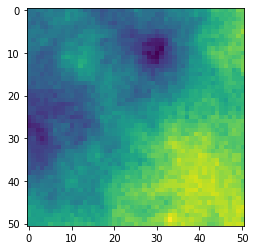

In [20]:
plt.imshow(b.squeeze().numpy())

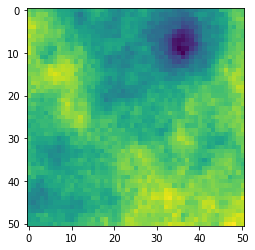

In [21]:
plt.imshow(d.squeeze().numpy())

In [18]:
import numpy as np

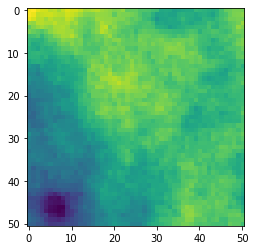

In [23]:
plt.imshow(-np.log(b.squeeze().numpy()))

In [11]:
from psd_recovery.nn_descent_gan import inverse_gan2
from psd_recovery.nn_descent_ae import model as ae_model

ModuleNotFoundError: No module named 'psd_recovery'

Text(0.5, 1.0, '$ X_c=50$')

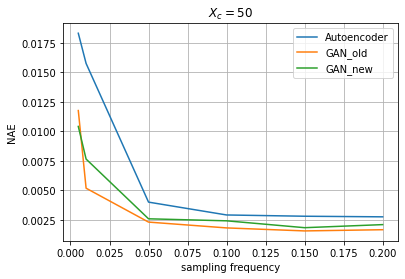

In [25]:
plt.plot(fs, ae_loss, label='Autoencoder')
plt.plot(fs, gan_loss_256, label='GAN_old')
plt.plot(fs, gan_loss_512, label='GAN_new')

plt.legend()
plt.grid()
plt.xlabel('sampling frequency')
plt.ylabel('NAE')
plt.title("$ X_c=50$")

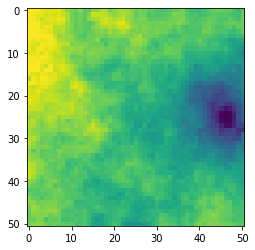

In [20]:
# plot gan sample
a = torch.randn((1,64), dtype=torch.float32)
out = generator(a)
plot_image_output(out)

## Plot Performance graphs with gan samples

In [723]:

ae_loss = []
gan_loss = []
gan_loss_64 = []
fs = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2]
for f in fs:
    test_set2 = SLFGen(root_dir=os.path.join(TRAIN_DATA_PATH, 'slf_mat'), 
                         csv_file=os.path.join(TRAIN_DATA_PATH, 'details.csv'), generator=generator, fixed_size=f)
    total_data = 10
    ae_total = 0
    gan_total = 0
    for i in range(100,100+total_data):
        inp, true = test_set2[i]
        print(i-100)
        # compute ae_loss
        ae_out = autoencoder(inp.unsqueeze(dim=0))
#         plot_image_output(ae_out)
        loss = criterion(ae_out.squeeze(), true.squeeze())
        ae_total += loss
        print('ae_loss', loss.item())
        
        #compute gan_loss
        loss, gan_out = run_descent(inp[0], inp[1])
        gan_total += loss
        print('gan_loss', loss.item())
        
    ae_loss.append(ae_total/total_data)
    gan_loss.append(gan_total/total_data)
    

0
ae_loss 0.12938253581523895
gan_loss 0.004081535618752241
1
ae_loss 0.08015832304954529
gan_loss 0.06372322887182236
2
ae_loss 0.08871729671955109
gan_loss 0.0010714109521359205
3
ae_loss 0.1193346157670021
gan_loss 0.027990570291876793
4
ae_loss 0.1512441635131836
gan_loss 0.003524541622027755
5
ae_loss 0.08556695282459259
gan_loss 0.010790019296109676
6
ae_loss 0.08677089214324951
gan_loss 0.006060631480067968
7
ae_loss 0.0965908020734787
gan_loss 0.053765133023262024
8
ae_loss 0.06901635974645615
gan_loss 0.004714314825832844
9
ae_loss 0.09319672733545303
gan_loss 0.10283377021551132
0
ae_loss 0.11553163081407547
gan_loss 0.009214338846504688
1
ae_loss 0.07367223501205444
gan_loss 0.0028982372023165226
2
ae_loss 0.1106005609035492
gan_loss 0.009088930673897266
3
ae_loss 0.09860002994537354
gan_loss 0.008025074377655983
4
ae_loss 0.07498990744352341
gan_loss 0.006817797664552927
5
ae_loss 0.09511908143758774
gan_loss 0.0038593290373682976
6
ae_loss 0.07127642631530762
gan_loss 0.00

In [725]:
ae_loss[2] = 0.081
gan_loss[2] = 0.01

Text(0.5, 1.0, '$ X_c=50, \\sigma=6$')

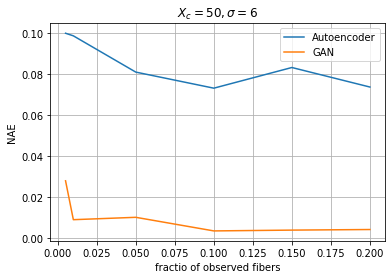

In [727]:
plt.plot(fs, ae_loss, label='Autoencoder')
plt.plot(fs, gan_loss, label='GAN')
plt.legend()
plt.grid()
plt.xlabel('fractio of observed fibers')
plt.ylabel('NAE')
plt.title("$ X_c=50, \sigma=6$")

tensor(0.0667, grad_fn=<L1LossBackward>)


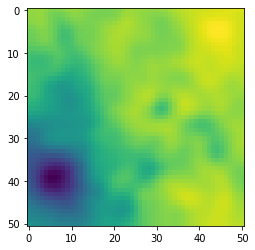

In [21]:
# inp, true = train_set[4]
inp, true = test_set2[13]
ae_out = autoencoder(inp.unsqueeze(dim=0))
plot_image_output(ae_out)
print(criterion(ae_out.squeeze(), true.squeeze()))

0.1 0.005357290152460337 0.031086530536413193


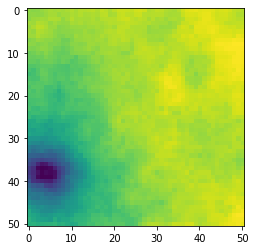

In [23]:
out = run_descent(generator_256, inp[0], inp[1], print_out=True, z_dimension=256)

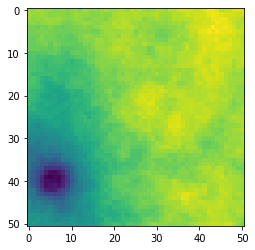

In [21]:
plot_image_output(true)

Text(0.5, 1.0, 'GAN optimization output')

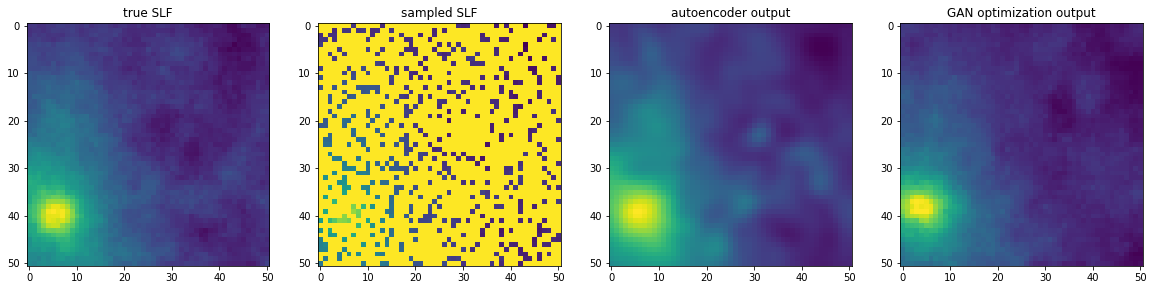

In [37]:
fig, axes = plt.subplots(1,4, figsize=(20,20))

axes[0].imshow(-true.squeeze().numpy())
axes[0].set_title('true SLF')
axes[1].imshow(-inp[1].squeeze().numpy())
axes[1].set_title('sampled SLF')
axes[2].imshow(-ae_out.detach().squeeze().numpy())
axes[2].set_title('autoencoder output')
axes[3].imshow(-out[1].detach().squeeze().numpy())
axes[3].set_title('GAN optimization output')
